# JUPYTER_NOTEBOOK_OPENGL_v10_synth_blur_variety_backs_7x7

# Pruebas con datos reales de la red Mask R-CNN para segmentación

### Importar bibliotecas de detectron2, os, random, matplotlib y opencv

In [1]:
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import get_detection_dataset_dicts
from detectron2.data import MetadataCatalog
from matplotlib import pyplot as plt
from detectron2.utils.visualizer import ColorMode
import os
import random
import cv2

### Registrar dataset con datos reales:

In [2]:
register_coco_instances("UCSP Fondecyt Dataset train", {}, "coco_dataset_train.json", "blurred_images")
register_coco_instances("UCSP Fondecyt test blurred video", {}, "coco_dataset_test_video.json", "images_piezas_videos_blurred")

### Visualizar 3 imágenes aleatorias del conjunto de datos de pruebas reales con sus etiquetas:

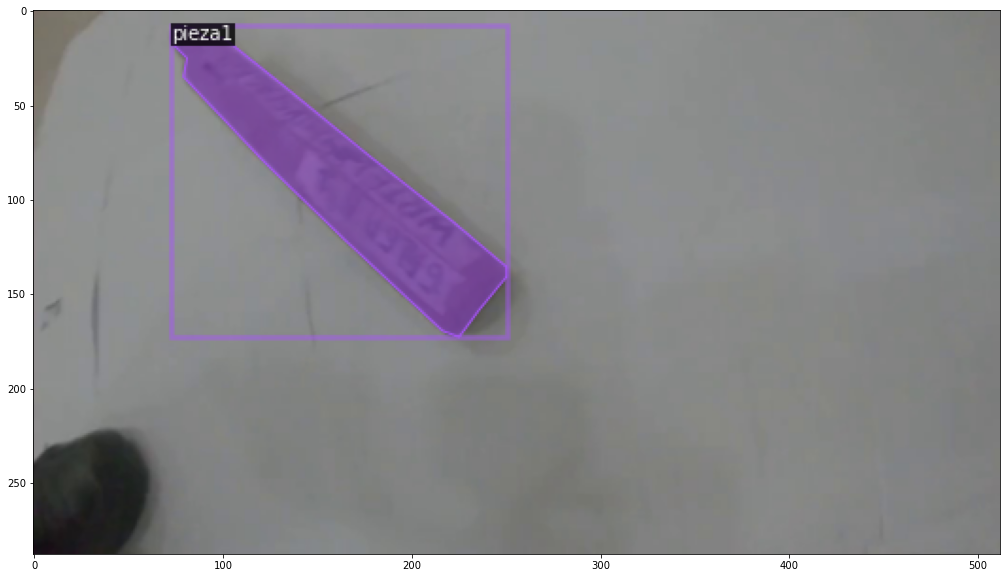

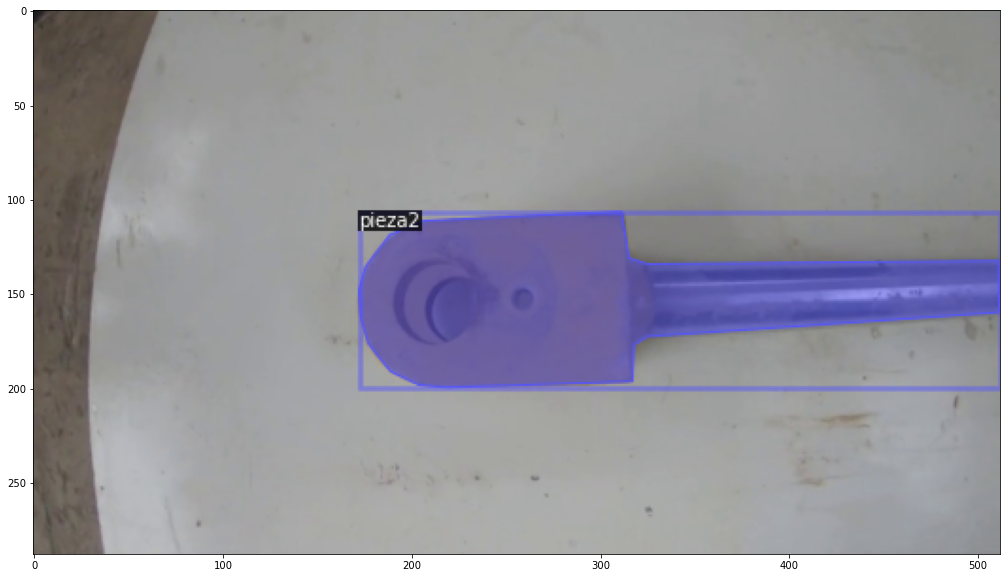

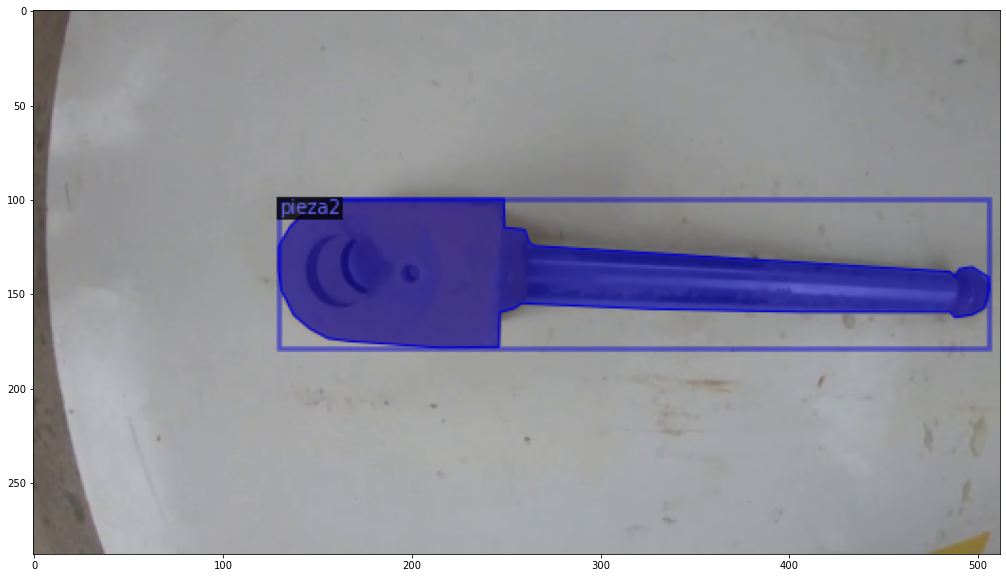

In [3]:
%matplotlib inline
dataset_dicts = get_detection_dataset_dicts(["UCSP Fondecyt test blurred video"])
dataset_metadata = MetadataCatalog.get("UCSP Fondecyt test blurred video")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(20,10))
    #plt.figure()
    plt.imshow(vis.get_image())

### Obtener un archivo de configuración y asignarle las configuraciones de nuestro modelo:

In [4]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("UCSP Fondecyt Dataset train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 3
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 4000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # only has one class (ballon)

### Configurar los parámetros para realizar las pruebas y crear un predictor:

In [5]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("UCSP Fondecyt Dataset test", )
predictor = DefaultPredictor(cfg)

### Crear una carpeta para guardar los pesos entrenados y los resultados de las pruebas, además crear un "trainer":

In [6]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 

[09/24 22:16:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[09/24 22:16:48 d2.data.datasets.coco]: Loaded 3069 images in COCO format from coco_dataset_train.json
[09/24 22:16:48 d2.data.build]: Removed 0 images with no usable annotations. 3069 images left.
[09/24 22:16:48 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   pieza0   | 1023         |   pieza1   | 1023         |   pieza2   | 1023         |
|            |              |            |              |            |              |
|   total    | 3069         |            |              |            |              |
[09/24 22:16:48 d2.data.common]: Serializing 3069 elements to byte tensors and concatenating them all ...
[09/24 22:16:48 d2.data.common]: Serialized dataset takes 2.47 MiB
[09/24 22:16:48 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640,

### Cargar pesos de la red neuronal si es que ya se ha entrenado:

In [7]:
trainer.resume_or_load(resume=False)

### Visualizar 10 ejemplos aleatorios de pruebas reales predichos:

[09/24 22:16:48 d2.data.datasets.coco]: Loaded 108 images in COCO format from coco_dataset_test_video.json
[09/24 22:16:48 d2.data.build]: Removed 0 images with no usable annotations. 108 images left.


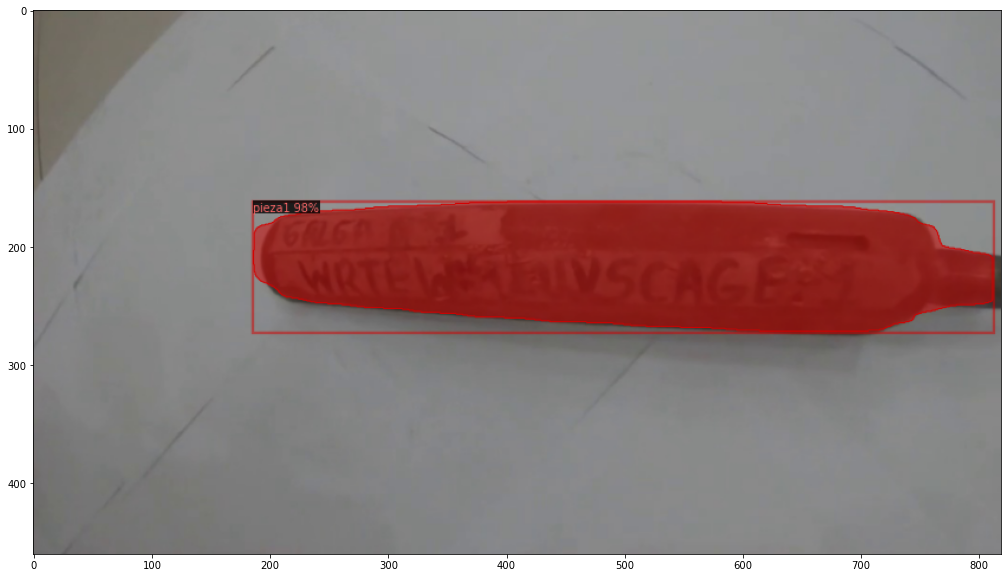

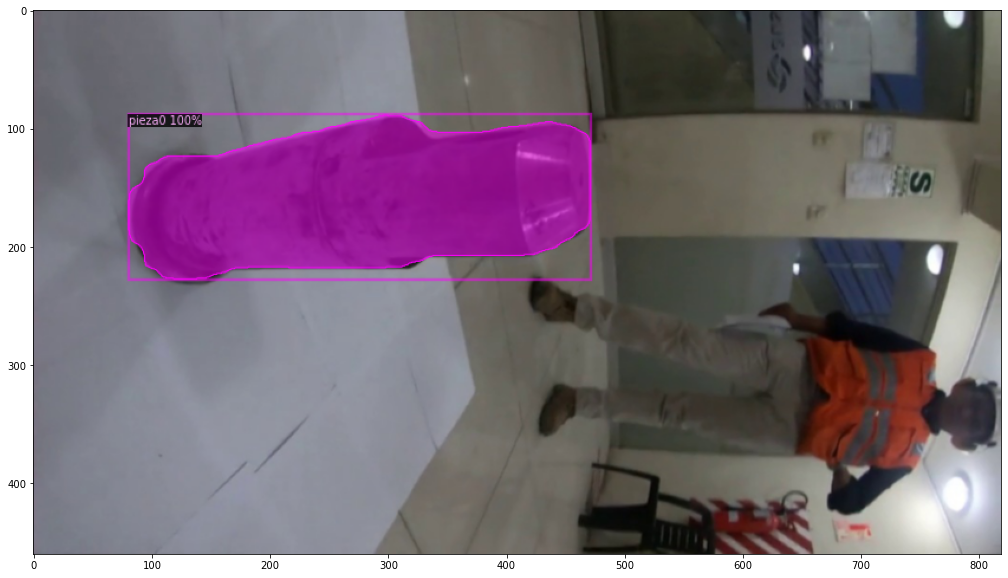

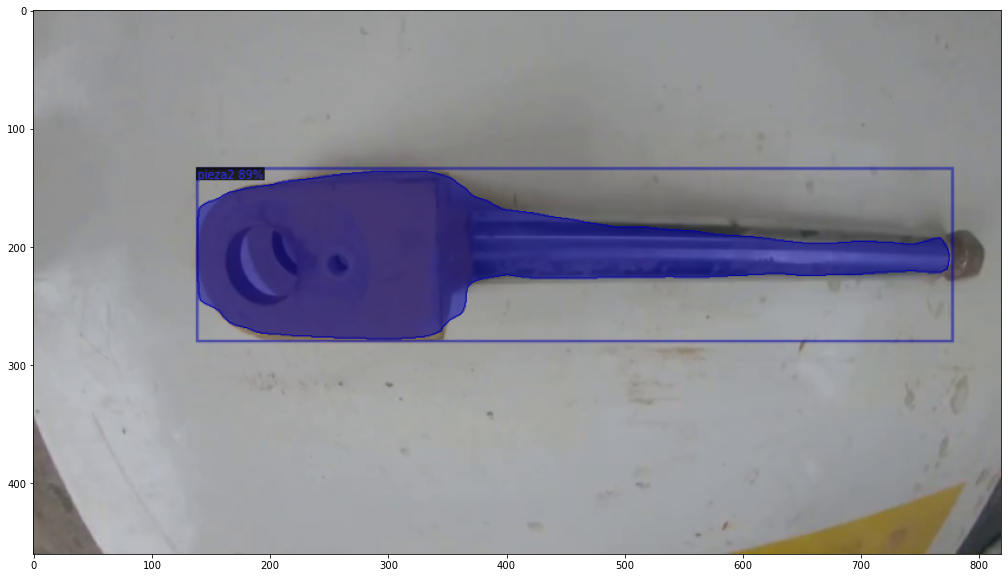

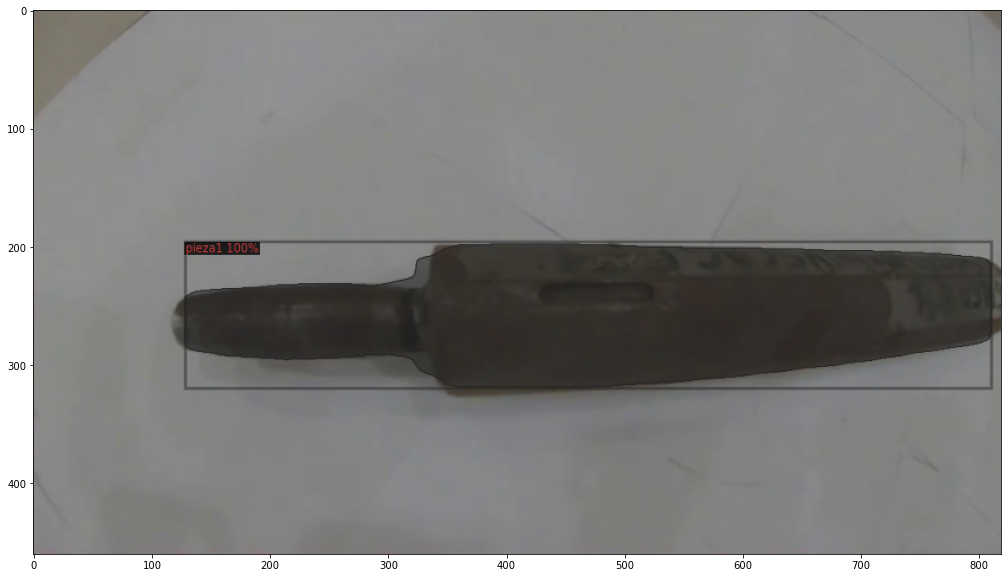

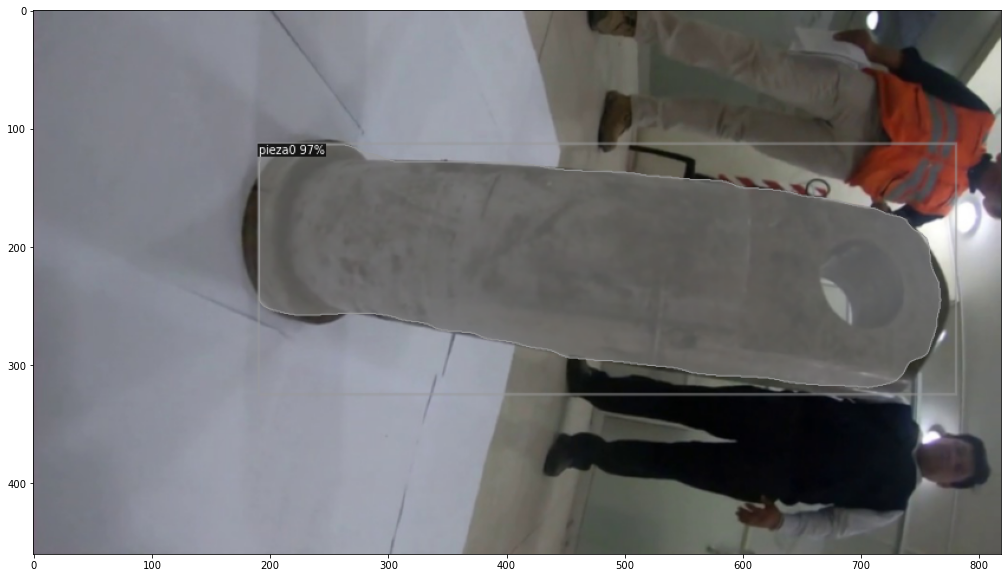

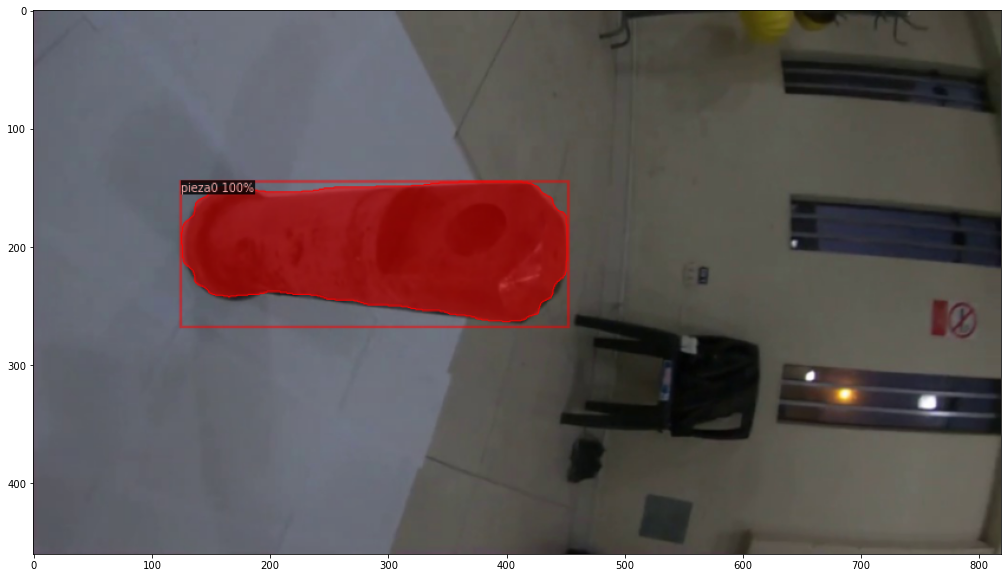

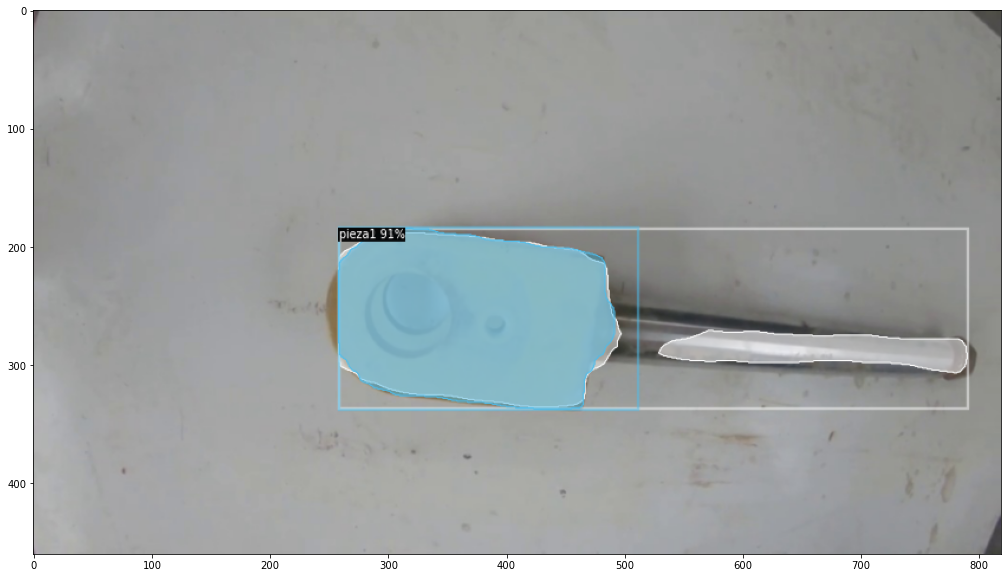

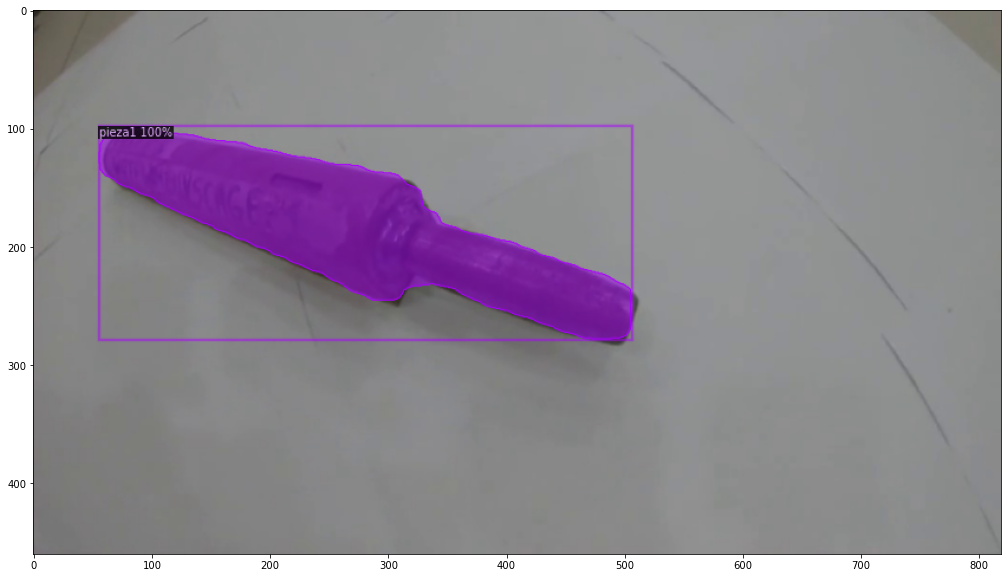

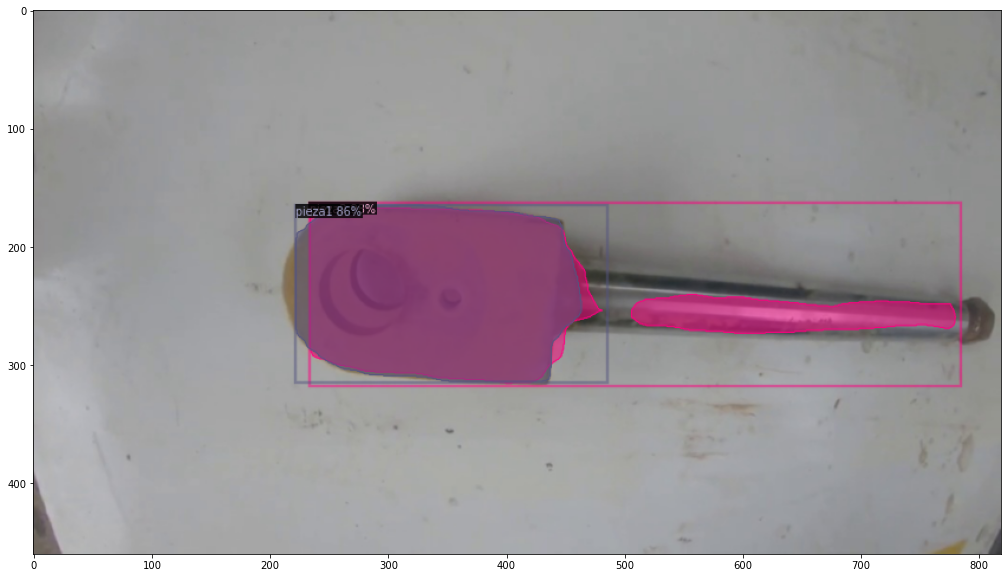

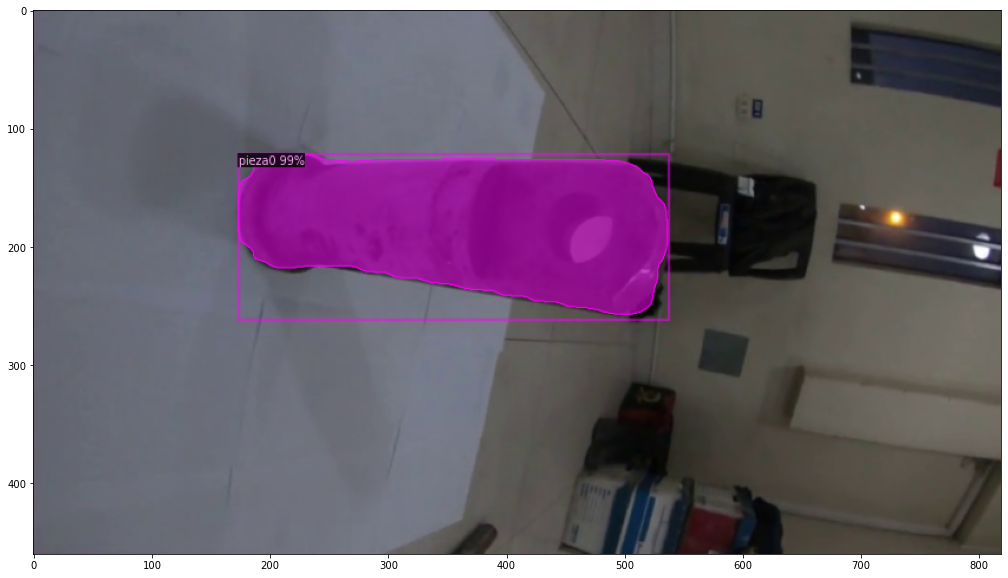

In [8]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = get_detection_dataset_dicts(["UCSP Fondecyt test blurred video"])
for d in random.sample(dataset_dicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=dataset_metadata, 
                   scale=0.8
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(20,10))
    #plt.figure()
    plt.imshow(v.get_image())

### Calcular la métrica mAP sobre el conjunto de pruebas reales:

In [9]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("UCSP Fondecyt test blurred video", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "UCSP Fondecyt test blurred video")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[09/24 22:16:56 d2.data.datasets.coco]: Loaded 108 images in COCO format from coco_dataset_test_video.json
[09/24 22:16:56 d2.data.common]: Serializing 108 elements to byte tensors and concatenating them all ...
[09/24 22:16:56 d2.data.common]: Serialized dataset takes 0.07 MiB
[09/24 22:16:56 d2.evaluation.evaluator]: Start inference on 108 images
[09/24 22:16:59 d2.evaluation.evaluator]: Inference done 11/108. 0.1267 s / img. ETA=0:00:12
[09/24 22:17:04 d2.evaluation.evaluator]: Inference done 51/108. 0.1233 s / img. ETA=0:00:07
[09/24 22:17:09 d2.evaluation.evaluator]: Inference done 91/108. 0.1228 s / img. ETA=0:00:02
[09/24 22:17:11 d2.evaluation.evaluator]: Total inference time: 0:00:13.093823 (0.127124 s / img per device, on 1 devices)
[09/24 22:17:11 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:12 (0.122629 s / img per device, on 1 devices)
[09/24 22:17:11 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/24 22:17:11 d2.evaluation.co

OrderedDict([('bbox',
              {'AP': 85.63296462639897,
               'AP50': 95.82458857472123,
               'AP75': 95.0765137672405,
               'APs': nan,
               'APm': nan,
               'APl': 85.65252511903361,
               'AP-pieza0': 92.3448071515226,
               'AP-pieza1': 88.81319189364379,
               'AP-pieza2': 75.74089483403054}),
             ('segm',
              {'AP': 84.79263410569526,
               'AP50': 95.0765137672405,
               'AP75': 91.47622763532114,
               'APs': nan,
               'APm': nan,
               'APl': 84.81376426749192,
               'AP-pieza0': 98.65988349987073,
               'AP-pieza1': 92.08831810652183,
               'AP-pieza2': 63.629700710693214})])